In [1]:
import json
import os
import shutil
import warnings
from datetime import datetime
from os.path import exists

In [2]:
import gensim.parsing.preprocessing as gsp
import joblib
import matplotlib.pyplot as plt
import mlflow
import nltk
import numpy as np
import pandas as pd
import tensorflow_hub as hub
from nltk import WordNetLemmatizer
from pandas import DataFrame
from sklearn import metrics
from sklearn.preprocessing import MultiLabelBinarizer
from stackapi import StackAPI

2024-09-18 10:20:37.945022: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-18 10:20:37.957482: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-18 10:20:37.961147: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-18 10:20:37.970914: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-18 10:20:38.940884: W tensorflow/compiler/tf2

In [3]:
warnings.filterwarnings("ignore", category=DeprecationWarning)

STACKAPI CONFIGURATION

In [4]:
SITE = StackAPI('stackoverflow')
SITE.max_pages = 25

MISC CONFIGURATION

In [5]:
plt.style.use("fivethirtyeight")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

PATHS

In [6]:
CACHED_2023_QUESTIONS_FILE = 'cached_questions_2023.json'
MODEL_PATH = 'models/supervised/best_supervised_model.model'
ML_LABELIZER_PATH = 'models/supervised/best_ml_binarizer.model'
EMBEDDER_PATH = 'models/supervised/embedder_model.model'

In [7]:
# NLTK
nltk.download('wordnet')
nltk.download('punkt')

lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /home/xavier/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/xavier/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


MLFlow

In [8]:
# mlflow.set_tracking_uri(uri="http://localhost:8080")
# mlflow.set_experiment("Stability Verification Experiment with CV")

In [9]:
def cache_questions_from_2023():
    """Fetches the questions of a given month with at least 10 votes."""
    # https://stackapi.readthedocs.io/en/latest/user/complex.html
    questions = SITE.fetch('questions',
                           fromdate=datetime(2023, 1, 1),
                           todate=datetime(2023, 12, 31),
                           min=10,
                           sort='votes',
                           filter='withbody'
                           )
    extracted_questions = questions['items']
    
    questions = [{
        "body": question['body'],
        "creation_date": question['creation_date'],
        "score": question['score'],
        "tags": question['tags'],
        "title": question['title']
    } for question in extracted_questions]
    
    with open(CACHED_2023_QUESTIONS_FILE, 'w', encoding='utf-8') as f:
        json.dump(questions, f, ensure_ascii=False, indent=4)

In [10]:
def add_datetime_to_question(question: dict):
    """Add a datetime field to the question."""
    question['creation_datetime'] = datetime.fromtimestamp(question['creation_date'])
    return question

In [11]:
def count_cached_questions_per_year():
    """Displays each year's number of cached questions."""
    with open('cached_questions.json', 'r', encoding='utf-8') as f:
        questions = json.load(f)
        
        min_timestamp = min([question['creation_date'] for question in questions])
        min_datetime = datetime.fromtimestamp(min_timestamp)
        
        max_timestamp = max([question['creation_date'] for question in questions])
        max_datetime = datetime.fromtimestamp(max_timestamp)
        
        print(f"The cached questions range from {min_datetime} to {max_datetime}.\n")
        
        enriched_questions = list(map(add_datetime_to_question, questions))
        
        for year in range(2010, 2024):
            number_of_questions_for_year = len([question for question in enriched_questions if question['creation_datetime'].year == year])
            print(f"Number of questions for year {year}: {number_of_questions_for_year}")

In [12]:
def count_cached_questions_per_month(questions):
    """Displays each year's number of cached questions."""
    min_timestamp = min([question['creation_date'] for question in questions])
    min_datetime = datetime.fromtimestamp(min_timestamp)
    
    max_timestamp = max([question['creation_date'] for question in questions])
    max_datetime = datetime.fromtimestamp(max_timestamp)
    
    print(f"The cached questions range from {min_datetime} to {max_datetime}.\n")
    
    for month in range(1, 13):
        number_of_questions_for_month = len([question for question in questions if question['creation_datetime'].month == month])
        print(f"Number of questions for month {month}: {number_of_questions_for_month}")

In [13]:
def load_cached_2023_questions():
    """Load questions from the cache file."""
    with open(CACHED_2023_QUESTIONS_FILE, 'r', encoding='utf-8') as f:
        return json.load(f)

In [14]:
def extract_and_clean_text(question: dict):
    """Create a new 'text' field for each question containing the cleaned, tokenized and lemmatized title + body."""
    title = question['title']
    body = question['body']
    text = f"{title} {body}"
    
    for filter in [gsp.strip_tags,
                   gsp.strip_punctuation,
                   gsp.strip_multiple_whitespaces,
                   gsp.strip_numeric,
                   gsp.remove_stopwords,
                   gsp.strip_short,
                   gsp.lower_to_unicode]:
        text = filter(text)
        
    cleaned_text = text.replace("quot", "")
    tokenized_text = nltk.tokenize.word_tokenize(cleaned_text)

    # words_stemmed = (stemmer.stem(w) for w in words_without_short_words)
    words_lemmatized = [lemmatizer.lemmatize(w) for w in tokenized_text]
    question['text'] = " ".join(words_lemmatized)

    # bigrams = nltk.bigrams(tokenized_text)
    # question['bigrams'] = [' '.join(bigram) for bigram in bigrams]

    # trigrams = nltk.trigrams(tokenized_text)
    # question['trigrams'] = [' '.join(trigram) for trigram in trigrams]
    
    return question

In [15]:
def create_results_plots(results):
    """Generate the plot showing the performances with each words embedding method for the Jaccard Score and Hamming Loss."""
    create_results_plot(results, "jaccard_score")
    create_results_plot(results, "hamming_loss")

In [16]:
def create_results_plot(results, metric):
    """Create results plot for a single metric."""
    performance_plot = (results[[metric, "month"]]
                        .plot(kind="bar", x="month", figsize=(15, 8), rot=0,
                              title=f"Models Performance Sorted by {metric}"))
    performance_plot.title.set_size(20)
    performance_plot.set(xlabel=None)
    
    plt.show()
    plt.close()

In [17]:
def send_scores_to_mlflow(last_result):
    """Send the scores to MLFlow."""
    with mlflow.start_run():
        mlflow.log_params({
            "month": last_result['month']
        })
        
        mlflow.log_metric("hamming_loss", last_result['hamming_loss'])
        mlflow.log_metric("jaccard_score", last_result['jaccard_score'])

Starting stability verification script.


Number of questions of 2023 with a minimum of 10 votes: 2152.

Starting month:1 verification with 275 questions.


/home/xavier/Desktop/formation/project_5/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['.net', '.net-7.0', '.net-core', 'accessibility', 'admob', 'ads', 'amazon-eks', 'amazon-rds', 'android-gradle-plugin', 'android-icons', 'android-jetpack-compose', 'android-manifest', 'android-permissions', 'android-sdk-manager', 'android-studio', 'android-studio-electric-eel', 'android-testing', 'angular', 'angular-material', 'angular-standalone-components', 'angular14', 'angular15', 'antd', 'apache-spark', 'apt', 'arm64', 'assembly', 'astronomy', 'authentication', 'avx2', 'avx512', 'aws-cdk', 'aws-lambda', 'aws-sam-cli', 'axios', 'azure', 'azure-active-directory', 'azure-ad-msal', 'azure-cognitive-services', 'azure-databricks', 'azure-openai', 'babeljs', 'bean-validation', 'benchmarking', 'bert-language-model', 'binding', 'bit-manipulation', 'bit-shift', 'blazor', 'blazor-webassembly', 'boilerplate', 'browser-extension', 'build.gradle', 'buil

Results of month:1 - Hamming loss:0.01631885356023287, jaccard_score:0.06545454545454546.

Starting month:2 verification with 242 questions.
Results of month:2 - Hamming loss:0.016182876684444084, jaccard_score:0.07134986225895316.

Starting month:3 verification with 263 questions.


/home/xavier/Desktop/formation/project_5/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['.net', '.net-6.0', '.net-7.0', '.net-core', 'admob', 'amazon-ecr', 'amazon-eks', 'amazon-web-services', 'android-emulator', 'android-gradle-plugin', 'android-jetpack', 'android-jetpack-compose', 'android-jetpack-compose-material3', 'android-keystore', 'android-library', 'android-livedata', 'android-livedata-transformations', 'android-studio', 'android-studio-electric-eel', 'android-tiramisu', 'angular', 'angular-material', 'angular15', 'angularfire', 'anr', 'apple-m1', 'apple-silicon', 'apt', 'asp.net', 'asp.net-core', 'asp.net-core-7.0', 'asp.net-core-mvc', 'asp.net-core-viewcomponent', 'asp.net-web-api', 'asynchronous-method-call', 'attributeerror', 'auth-guard', 'authentication', 'automation', 'avif', 'aws-config', 'aws-lambda', 'aws-sdk', 'aws-sdk-js', 'axios', 'azure', 'azure-functions', 'azure-web-app-service', 'barcode-scanner', 'bitbu

Results of month:3 - Hamming loss:0.016164378430013674, jaccard_score:0.04892268694550063.

Starting month:4 verification with 226 questions.
Results of month:4 - Hamming loss:0.016783643576441867, jaccard_score:0.07168141592920353.

Starting month:5 verification with 221 questions.


/home/xavier/Desktop/formation/project_5/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['.net', 'alpine-linux', 'amazon-ec2', 'amazon-ecs', 'amazon-linux', 'amazon-s3', 'amazon-web-services', 'anaconda', 'android-appcompat', 'android-canvas', 'android-gradle-plugin', 'android-instrumentation', 'android-jetpack-compose', 'android-jetpack-compose-canvas', 'android-jetpack-compose-material3', 'android-lifecycle', 'android-manifest', 'android-r8', 'android-security', 'android-studio', 'android-testing', 'angular', 'apache-commons-email', 'apache-spark', 'apple-m1', 'appstore-approval', 'asdf', 'asp.net-core', 'astrojs', 'attributeerror', 'audio-recording', 'authentication', 'aws-cloudmap', 'aws-event-bridge', 'aws-service-connect', 'axios', 'azure', 'azure-functions', 'azure-functions-runtime', 'azure-managed-identity', 'azure-powershell', 'babeljs', 'barcode', 'birthday-paradox', 'blockchain', 'build', 'c', 'c#', 'c++14', 'c++17', '

Results of month:5 - Hamming loss:0.015669928448833113, jaccard_score:0.06938159879336349.

Starting month:6 verification with 172 questions.
Results of month:6 - Hamming loss:0.016754496505899875, jaccard_score:0.0568798449612403.

Starting month:7 verification with 153 questions.


/home/xavier/Desktop/formation/project_5/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['.net', '.net-8.0', '.net-core', 'ackermann', 'admob', 'aem', 'alpine-linux', 'amazon-s3', 'amazon-web-services', 'android-14', 'android-api-34', 'android-build', 'android-compose-textfield', 'android-gradle-plugin', 'android-jetpack-compose', 'android-r8', 'android-securityexception', 'android-studio', 'android-studio-flamingo', 'angular', 'angular-in-memory-web-api', 'angular-material', 'angular-standalone-components', 'angular12', 'angular13', 'antd', 'app-router', 'app-store', 'appintents', 'appium', 'asp.net', 'asp.net-core', 'auto', 'automatic-storage', 'avd-manager', 'aws-batch', 'aws-fargate', 'aws-lambda', 'azure', 'azure-aks', 'azure-cli', 'azure-openai', 'babeljs', 'bit-manipulation', 'boto3', 'build', 'build-runner', 'built-value', 'bundle', 'c', 'c#', 'c++-attributes', 'c++11', 'c++17', 'c++20', 'c++23', 'carthage', 'certbot', 'ch

Results of month:7 - Hamming loss:0.015969606233297916, jaccard_score:0.07309368191721133.

Starting month:8 verification with 155 questions.
Results of month:8 - Hamming loss:0.01709836326076593, jaccard_score:0.043333333333333335.

Starting month:9 verification with 127 questions.
Results of month:9 - Hamming loss:0.017066832163220975, jaccard_score:0.0363517060367454.

Starting month:10 verification with 126 questions.


/home/xavier/Desktop/formation/project_5/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['.net', '.net-4.8', '.net-6.0', '.net-7.0', '.net-core', 'accelerate', 'action', 'admob', 'airflow', 'amazon-ecs', 'amazon-rds', 'amazon-sagemaker-studio', 'amazon-web-services', 'android-14', 'android-broadcast', 'android-camera', 'android-camera2', 'android-gradle-plugin', 'android-jetpack-compose', 'android-permissions', 'android-settings', 'android-studio', 'android-workmanager', 'apache-arrow', 'appcenter', 'artificial-intelligence', 'asp.net-core', 'attributes', 'auth0', 'authentication', 'auto-vectorization', 'automation', 'backend', 'benchmarking', 'beta', 'bitwise-operators', 'bots', 'broadcastreceiver', 'browser-history', 'build.gradle', 'byte', 'c', 'c#', 'c++-concepts', 'c++-modules', 'c++11', 'c++17', 'c++20', 'c17', 'c23', 'chatbot', 'chromadb', 'chromium', 'cicd', 'circular-buffer', 'clang', 'clerk', 'clion', 'combinations', 'co

Results of month:10 - Hamming loss:0.017319571506763626, jaccard_score:0.04113756613756613.

Starting month:11 verification with 116 questions.
Results of month:11 - Hamming loss:0.016137251571258705, jaccard_score:0.049999999999999996.

Starting month:12 verification with 76 questions.
Results of month:12 - Hamming loss:0.016917293233082706, jaccard_score:0.035526315789473684.



/home/xavier/Desktop/formation/project_5/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['.net', '.net-8.0', 'aggregate-initialization', 'airflow', 'amazon-elastic-beanstalk', 'amazon-web-services', 'anaconda3', 'android-gradle-plugin', 'android-jetpack-compose', 'android-jetpack-navigation', 'android-manifest', 'android-studio', 'angular', 'angular-language-service', 'angular17', 'angular18', 'arraylist', 'artificial-intelligence', 'asp.net', 'asp.net-core', 'asp.net-core-8', 'asp.net-core-webapi', 'asp.net-routing', 'avx512', 'awk', 'azure', 'azure-web-app-service', 'bionic', 'blazor', 'blazor-auto', 'blazor-server-side', 'build.gradle', 'c', 'c#', 'c#-12.0', 'c++-chrono', 'c++-concepts', 'c++14', 'c++20', 'c++23', 'c23', 'calling-convention', 'catboost', 'certificate', 'chat-gpt-4', 'chatgpt-api', 'clang', 'cloudinary', 'constructor', 'cpython', 'cross-platform', 'dart', 'datetime', 'deprecated', 'designated-initializer', 'dis'

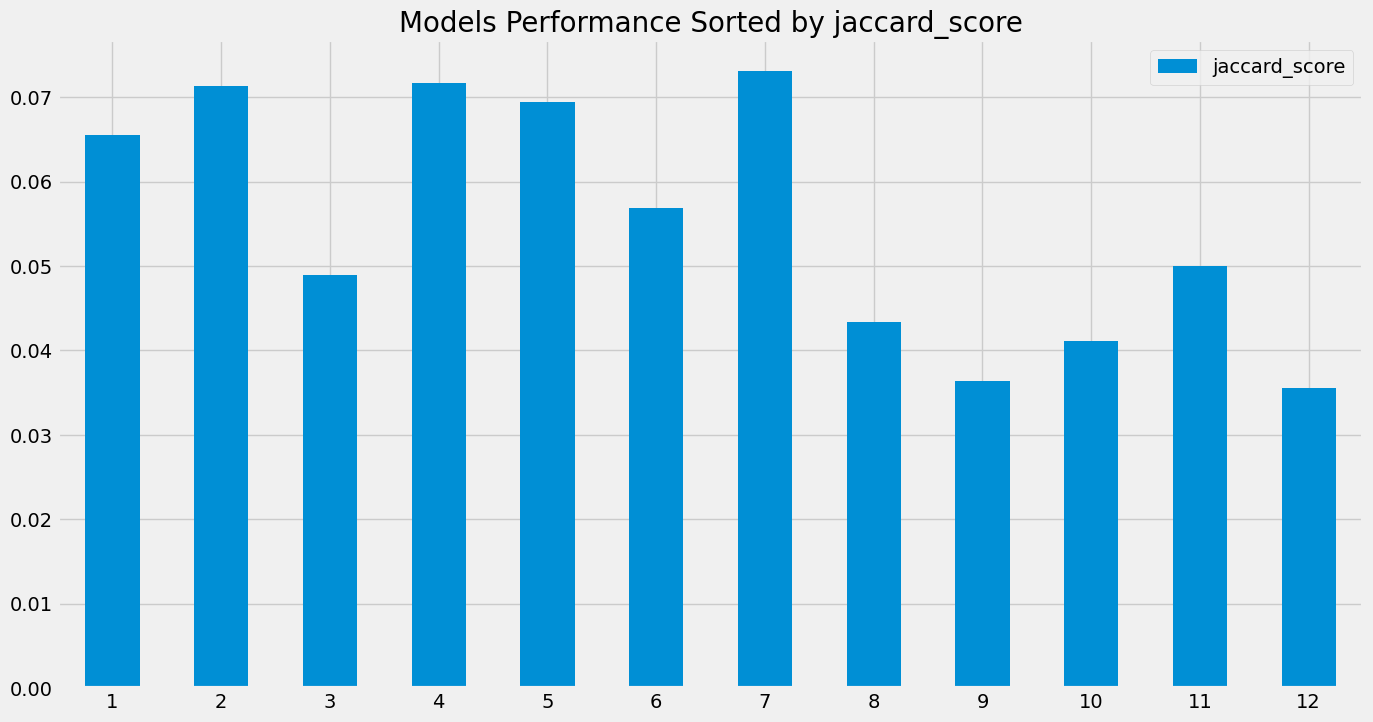

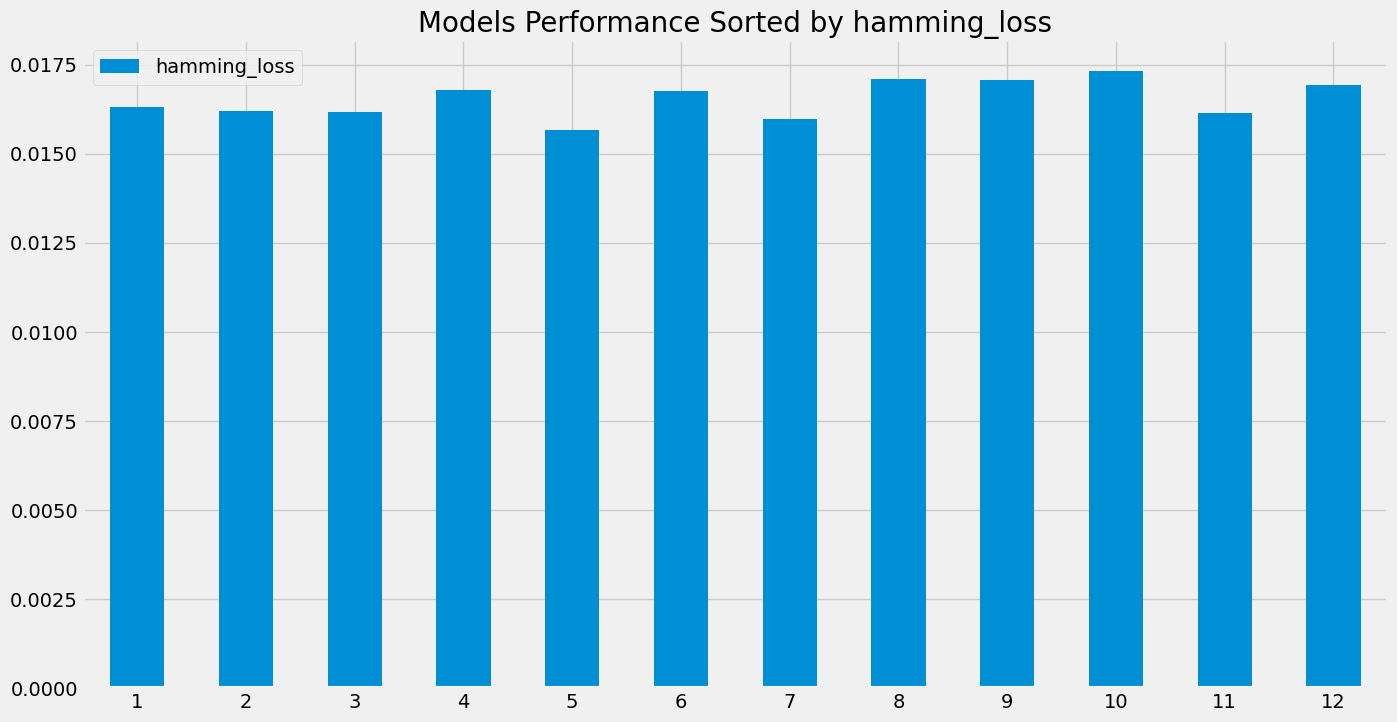


Stability verification script finished.



In [18]:
print("Starting stability verification script.\n")

if not exists(CACHED_2023_QUESTIONS_FILE):
    print(f"Cached questions are missing, downloading them in {CACHED_2023_QUESTIONS_FILE}.\n")
    cache_questions_from_2023()

cached_questions_2023 = load_cached_2023_questions()
print(f"\nNumber of questions of 2023 with a minimum of 10 votes: {len(cached_questions_2023)}.\n")

cached_questions_2023 = list(map(add_datetime_to_question, cached_questions_2023))
cached_questions_2023 = list(map(extract_and_clean_text, cached_questions_2023))

model = joblib.load(MODEL_PATH)
label_binarizer = joblib.load(ML_LABELIZER_PATH)
words_embedder = joblib.load(EMBEDDER_PATH)

# unique_tags = set([tag for tags in json_tags.values() for tag in tags])
# cached_questions_2023 = [question for question in cached_questions_2023
#                          if all(tag in unique_tags for tag in question['tags'])]

results = []
for month in range(1, 13):
    current_month_questions = DataFrame([question for question in cached_questions_2023
                                         if question['creation_datetime'].month == month])
    print(f"Starting month:{month} verification with {len(current_month_questions)} questions.")

    y_test = label_binarizer.transform(current_month_questions['tags'])

    questions_without_tags = current_month_questions.drop(columns=['tags'], axis=1)
    x_test = words_embedder.transform(questions_without_tags["text"])

    predictions_test_y = model.predict(x_test)

    hamming_loss = metrics.hamming_loss(y_true=y_test, y_pred=predictions_test_y)
    jaccard_score = metrics.jaccard_score(y_true=y_test, y_pred=predictions_test_y, average='samples', zero_division=0)
    results.append({
        "month": month,
        "hamming_loss": hamming_loss,
        "jaccard_score": jaccard_score
    })

    print(f"Results of month:{month} - Hamming loss:{hamming_loss}, jaccard_score:{jaccard_score}.\n")

    # send_scores_to_mlflow(results[-1])

create_results_plots(DataFrame(results))

print("\nStability verification script finished.\n")